In [1]:
from google.colab import drive # loads a library to mount your google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/My Drive/"

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

In [4]:

# Define constants
IMAGE_SIZE = (75, 75)  # InceptionV3 input size
BATCH_SIZE = 18
NUM_CLASSES = 4
EPOCHS = 80

In [5]:
train_data_dir = "/content/drive/My Drive/Dataset_tumor/Training/"
test_data_dir = '/content/drive/My Drive/Dataset_tumor/Testing/'

In [6]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split data into training/validation
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)



Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [8]:
# Load InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 [==============================] - 1s 0us/step


In [9]:
# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/80
128/128 [==============================] - 670s 5s/step - loss: 1.1890 - accuracy: 0.5777 - val_loss: 0.9868 - val_accuracy: 0.5585
Epoch 2/80
128/128 [==============================] - 18s 140ms/step - loss: 0.7377 - accuracy: 0.7079 - val_loss: 0.9867 - val_accuracy: 0.5881
Epoch 3/80
128/128 [==============================] - 18s 144ms/step - loss: 0.6677 - accuracy: 0.7414 - val_loss: 1.0122 - val_accuracy: 0.5846
Epoch 4/80
128/128 [==============================] - 18s 143ms/step - loss: 0.6214 - accuracy: 0.7440 - val_loss: 0.9441 - val_accuracy: 0.5812
Epoch 5/80
128/128 [==============================] - 18s 140ms/step - loss: 0.6143 - accuracy: 0.7562 - val_loss: 0.8309 - val_accuracy: 0.6475
Epoch 6/80
128/128 [==============================] - 18s 140ms/step - loss: 0.5289 - accuracy: 0.7884 - val_loss: 0.9915 - val_accuracy: 0.5934
Epoch 7/80
128/128 [==============================] - 18s 140ms/step - loss: 0.5342 - accuracy: 0.7910 - val_loss: 1.0119 - val_accu

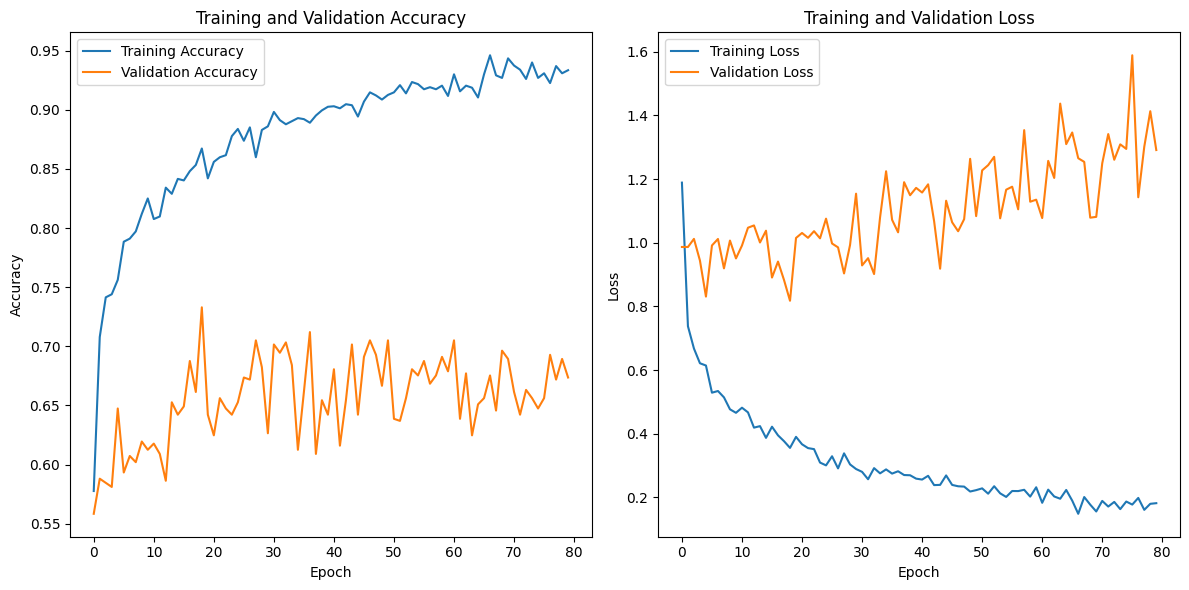

In [10]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)






In [11]:
# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluate model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Get predictions for the test set
Y_pred = model.predict(test_generator)
y_pred = tf.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred))

# Calculate AUC
auc_score = roc_auc_score(y_true, Y_pred, multi_class='ovr')
print(f'AUC Score: {auc_score}')

Found 394 images belonging to 4 classes.
22/22 [==============================] - 77s 4s/step - loss: 2.9868 - accuracy: 0.6904
Test accuracy: 0.6903553009033203
22/22 [==============================] - 3s 79ms/step
              precision    recall  f1-score   support

           0       0.94      0.34      0.50       100
           1       0.60      0.97      0.74       115
           2       0.73      0.94      0.82       105
           3       0.77      0.36      0.50        74

    accuracy                           0.69       394
   macro avg       0.76      0.66      0.64       394
weighted avg       0.75      0.69      0.66       394

AUC Score: 0.8521308693502843
